# Cox-PH and DeepSurv

In this notebook we will train the [Cox-PH method](http://jmlr.org/papers/volume20/18-424/18-424.pdf), also known as [DeepSurv](https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/s12874-018-0482-1).
We will use the METABRIC data sets as an example

A more detailed introduction to the `pycox` package can be found in [this notebook](https://nbviewer.jupyter.org/github/havakv/pycox/blob/master/examples/01_introduction.ipynb) about the `LogisticHazard` method.

The main benefit Cox-CC (and the other Cox methods) has over Logistic-Hazard is that it is a continuous-time method, meaning we do not need to discretize the time scale.

In [789]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
import pandas as pd
import torch
import torchtuples as tt
from sklearn.model_selection import train_test_split
from pycox.datasets import metabric
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv

In [790]:
## Uncomment to install `sklearn-pandas`
# ! pip install sklearn-pandas

In [791]:
np.random.seed(1234)
_ = torch.manual_seed(123)

## Dataset

We load the METABRIC data set and split in train, test and validation.

In [792]:

df_ = pd.read_csv('train_data.csv')
df_test = pd.read_csv('test_data.csv')

selected = pd.read_csv("top_features.csv")['Variable'].to_list() + ['OS_MONTHS', 'OS_STATUS']

df_ = df_[selected]
df_test = df_test[selected]
df_.rename(columns={'OS_MONTHS': 'duration', "OS_STATUS": 'event'}, inplace=True)
df_test.rename(columns={'OS_MONTHS': 'duration', "OS_STATUS": 'event'}, inplace=True)

df_train, df_val = train_test_split(df_, test_size=0.25, random_state=0)

In [793]:
df_train.head()

,RNF114,OR52A4,ARL6,OR4C3,HIGD1A,MIR1284,RNU4ATAC7P,MIR4274,MAL,PRUNE2,...,RNA5SP135,VAMP1,LIN54,E2F1,ZNF215,MUC5B,SLC47A2,TMEM128,duration,event
250,1.895925,-0.090329,-0.167887,-0.103162,0.055891,-0.046966,1.837793,0.392527,-0.444953,-0.104938,...,-0.041658,-0.247535,0.399438,2.112782,-0.077886,-0.085839,0.684636,0.385165,15.01,0
63,0.373201,1.952360,0.845898,2.194408,1.031349,0.923944,0.402269,-1.136861,-0.422314,0.073845,...,0.899961,2.586254,-1.222554,0.417783,1.980144,1.926147,-0.284708,-1.142945,34.00,0
312,-0.623514,-0.124951,-0.275633,-0.141615,-0.077801,-0.126702,-0.602227,0.529829,-0.450613,1.531320,...,-0.118989,0.918481,0.363035,-0.605779,-0.112768,-0.119940,1.596281,0.316571,95.11,0
159,1.178192,-0.047052,-1.676322,-0.035869,-1.706864,-1.491605,1.213545,-1.159744,0.517188,-0.081619,...,-1.442716,0.981201,0.306406,1.166208,-0.034284,-0.043212,-0.448573,-1.165809,14.52,1
283,0.412529,0.035175,0.219017,0.036230,-0.176832,-0.220510,0.441904,-2.010251,-0.337420,-0.011660,...,-0.209967,-0.207622,2.595803,0.458170,0.048561,0.037779,-0.767072,-2.015606,34.99,0


## Feature transforms
We have 9 covariates, in addition to the durations and event indicators.

We will standardize the 5 numerical covariates, and leave the binary variables as is. As variables needs to be of type `'float32'`, as this is required by pytorch.

In [794]:
cols_standardize = filtered_list = [x for x in df_train.columns if x not in ['duration', 'event']]
cols_leave = []

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [795]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

We need no label transforms

In [796]:
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
durations_test, events_test = get_target(df_test)
val = x_val, y_val

## Neural net

We create a simple MLP with two hidden layers, ReLU activations, batch norm and dropout. 
Here, we just use the `torchtuples.practical.MLPVanilla` net to do this.

Note that we set `out_features` to 1, and that we have not `output_bias`.

In [797]:
in_features = x_train.shape[1]
num_nodes = [64, 64, 16, 16]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

## Training the model

To train the model we need to define an optimizer. You can choose any `torch.optim` optimizer, but here we instead use one from `tt.optim` as it has some added functionality.
We use the `Adam` optimizer, but instead of choosing a learning rate, we will use the scheme proposed by [Smith 2017](https://arxiv.org/pdf/1506.01186.pdf) to find a suitable learning rate with `model.lr_finder`. See [this post](https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6) for an explanation.

In [798]:
model = CoxPH(net, tt.optim.Adam)

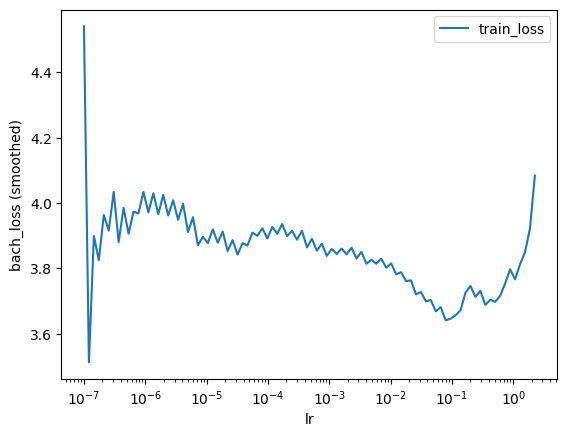

In [799]:
batch_size = 256
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=10)
_ = lrfinder.plot()

In [800]:
lrfinder.get_best_lr()

0.0001

Often, this learning rate is a little high, so we instead set it manually to 0.01

In [801]:
model.optimizer.set_lr(0.01)

We include the `EarlyStopping` callback to stop training when the validation loss stops improving. After training, this callback will also load the best performing model in terms of validation loss.

In [802]:
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [803]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

0:	[0s / 0s],		train_loss: 4.0029,	val_loss: 3.3730
1:	[0s / 0s],		train_loss: 3.6758,	val_loss: 3.2573
2:	[0s / 0s],		train_loss: 3.7544,	val_loss: 3.2130
3:	[0s / 0s],		train_loss: 3.6232,	val_loss: 3.2063
4:	[0s / 0s],		train_loss: 3.6228,	val_loss: 3.1920
5:	[0s / 0s],		train_loss: 3.3157,	val_loss: 3.1464
6:	[0s / 0s],		train_loss: 3.1714,	val_loss: 3.1001
7:	[0s / 0s],		train_loss: 3.1165,	val_loss: 3.0755
8:	[0s / 0s],		train_loss: 3.2657,	val_loss: 3.0833
9:	[0s / 0s],		train_loss: 2.9217,	val_loss: 3.1560
10:	[0s / 0s],		train_loss: 3.2518,	val_loss: 3.2600
11:	[0s / 0s],		train_loss: 2.4025,	val_loss: 3.3464
12:	[0s / 0s],		train_loss: 2.8181,	val_loss: 3.3722
13:	[0s / 0s],		train_loss: 2.3586,	val_loss: 3.4299
14:	[0s / 0s],		train_loss: 2.1168,	val_loss: 3.5936
15:	[0s / 0s],		train_loss: 2.5068,	val_loss: 3.8629
16:	[0s / 0s],		train_loss: 3.2894,	val_loss: 3.8677
17:	[0s / 0s],		train_loss: 1.6100,	val_loss: 3.8969
CPU times: user 152 ms, sys: 96.1 ms, total: 248 ms
Wall

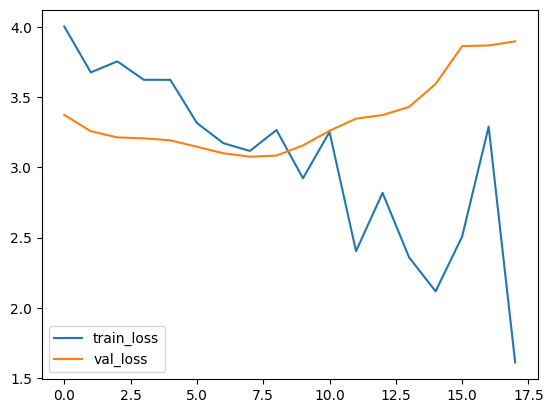

In [804]:
_ = log.plot()

We can get the partial log-likelihood

In [805]:
# model.partial_log_likelihood(*val).mean()

## Prediction

For evaluation we first need to obtain survival estimates for the test set.
This can be done with `model.predict_surv` which returns an array of survival estimates, or with `model.predict_surv_df` which returns the survival estimates as a dataframe.

However, as `CoxPH` is semi-parametric, we first need to get the non-parametric baseline hazard estimates with `compute_baseline_hazards`. 

Note that for large datasets the `sample` argument can be used to estimate the baseline hazard on a subset.

In [806]:
_ = model.compute_baseline_hazards()


In [807]:
surv = model.predict_surv_df(x_test)

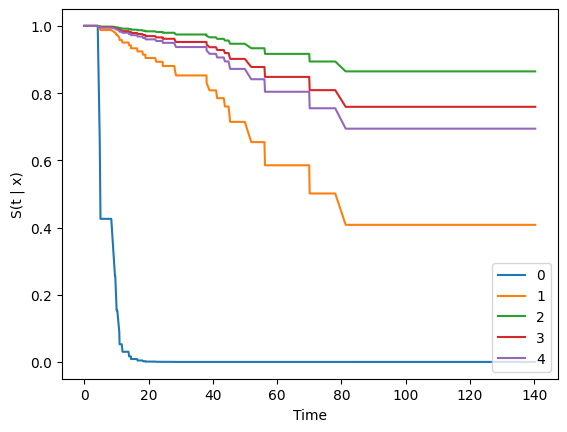

In [808]:
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

## Evaluation

We can use the `EvalSurv` class for evaluation the concordance, brier score and binomial log-likelihood. Setting `censor_surv='km'` means that we estimate the censoring distribution by Kaplan-Meier on the test set.

In [809]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

/Users/haily/.pyenv/versions/3.11.5/lib/python3.11/site-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


In [810]:
ev.concordance_td()

0.6720741599073001

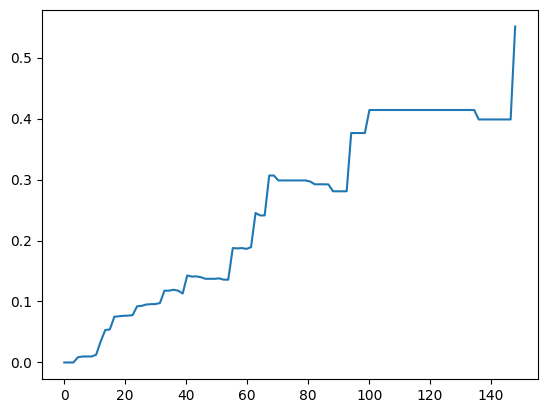

In [811]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = ev.brier_score(time_grid).plot()

In [812]:
ev.integrated_brier_score(time_grid)

0.2524529747130104

In [813]:
ev.integrated_nbll(time_grid)

0.7189570271793967

Text(0.5, 1.0, 'Risk Scores of Samples')

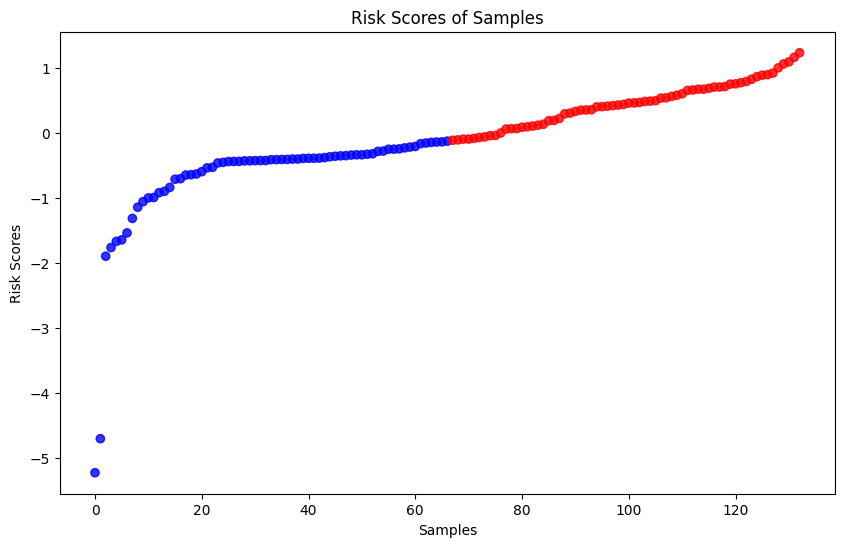

In [832]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# Assuming predictions is the output of model.predict_surv(x_test)
predictions = model.predict(x_test)

# print('predictions: ', predictions)

# Step 1: Calculate Risk Scores
risk_scores = -np.median(predictions, axis=1)  # Taking median of the survival probabilities as risk scores
# print('risk_scores: ', risk_scores)

# Step 2: Determine Threshold
threshold = np.median(risk_scores)

# Step 3: Assign Group Labels
risk_groups = np.where(risk_scores > threshold, "High Risk", "Low Risk")

df_test['risk_groups'] = risk_groups
# print('risk_groups: ', risk_groups)

# Step 4: Display distribution of risk groups
# print(pd.Series(risk_groups).value_counts())

# Step 5: Plot risk scores against samples using a scatter plot
sorted_indices = np.argsort(risk_scores)
sorted_risk_scores = risk_scores[sorted_indices]
sorted_risk_groups = risk_groups[sorted_indices]

# Map risk groups to colors
colors = np.where(sorted_risk_groups == 'High Risk', 'r', 'b')

plt.figure(figsize=(10, 6))
plt.scatter(range(len(risk_scores)), sorted_risk_scores, c=colors, alpha=0.8)
plt.xlabel('Samples')
plt.ylabel('Risk Scores')
plt.title('Risk Scores of Samples')

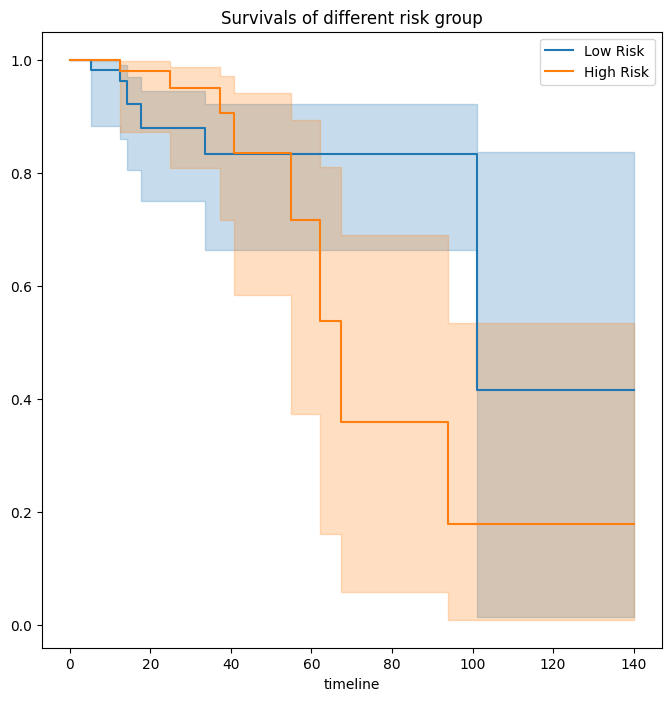

In [833]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

high_risk = df_test["risk_groups"] == 'High Risk'

ax = plt.subplot(111)
plt.gcf().set_size_inches(8, 8)  # Set figure size to 10x8 inches

T = df_test['duration']
E = df_test['event']

t = np.linspace(0, 140, 80)

kmf.fit(T[~high_risk], event_observed=E[~high_risk], timeline=t, label="Low Risk")
ax = kmf.plot_survival_function(ax=ax)

kmf.fit(T[high_risk], event_observed=E[high_risk],timeline=t, label="High Risk")
ax = kmf.plot_survival_function(ax=ax)

plt.title("Survivals of different risk group");